# Twitter Sentiment Analysis - Differents vectorization techniques, Random Forest, RNN

## 1. The dataset
This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .
It contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
np.random.seed(0)

# filename = os.listdir("input")[0]
path = os.path.join("../input", "sentiment140/training.1600000.processed.noemoticon.csv")
df = pd.read_csv(path, encoding='ISO-8859-1', names = ['target','ids','date','flag','user','text'])

In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


I will only keep the 2 columns that interest us.

In [4]:
df = df[['target', 'text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


I check if any values are missing.

In [5]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [6]:
df.target.unique()

array([0, 4])

There is no **neutral tweet**.

<AxesSubplot:xlabel='target', ylabel='count'>

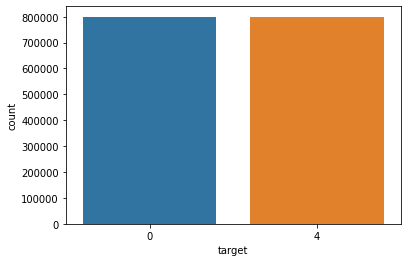

In [7]:
import seaborn as sns
sns.countplot(df.target)

There are 800,000 positive tweets and 800,000 negative tweets.

I will replace the **'4'** of **'positive'** with **'1'** for clarity.

In [8]:
df['target'] = df['target'].replace(4,1)

Since the database is large, I'm going to divide the size of each category of tweets by **50**.

In [9]:
# splitting categories
df_positive = df[df['target'] == 1]
df_negative = df[df['target'] == 0]
# sampling
df_positive = df_positive.iloc[:16000]
df_negative = df_negative.iloc[:16000]
# concatenation
df = pd.concat([df_positive, df_negative])
len(df)

32000

So I went from **1.6 million** tweets to **32,000** tweets.

## 2. Data cleaning and processing

### 2.1 Cleaning
Removing usernames and links.

Removing punctuation

Removing stop words

In [10]:
import re, string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # miniscule
    text = text.lower()
    
    # removing usernames
    text = re.sub('@[^\s]+', '', text)

    # removing links
    text = re.sub('((https?://[^\s]+)|(www\.[^\s]+))','',text)
    
    # removing punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    
    # tokenization
    tokens = word_tokenize(text)
   
    # suppression of stop words and lemmatization
    wordLemm = WordNetLemmatizer()
    final_words = []
    for token in tokens:
      # suppression of stop words
      if token not in stop_words and len(token) > 1:
        lemm = wordLemm.lemmatize(token)
        final_words.append(lemm)
    return ' '.join(final_words)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,target,text,cleaned_text
800000,1,I LOVE @Health4UandPets u guys r the best!!,love guy best
800001,1,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...
800003,1,Being sick can be really cheap when it hurts t...,sick really cheap hurt much eat real food plus...
800004,1,@LovesBrooklyn2 he has that effect on everyone,effect everyone


In [12]:
df.isnull().sum()

target          0
text            0
cleaned_text    0
dtype: int64

### 2.2 Wordcloud by class (positive / negative)

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Text(0.5, 1.0, 'Tweets positifs')

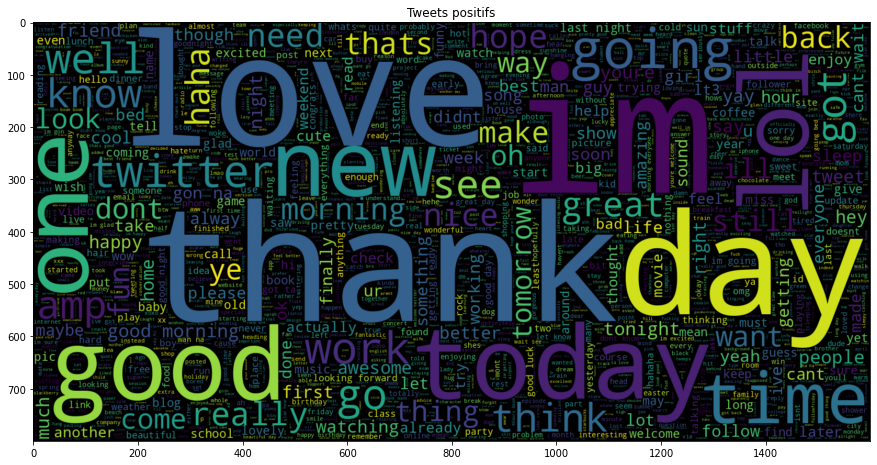

In [14]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 1].cleaned_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Tweets positifs')

Text(0.5, 1.0, 'Tweets négatifs')

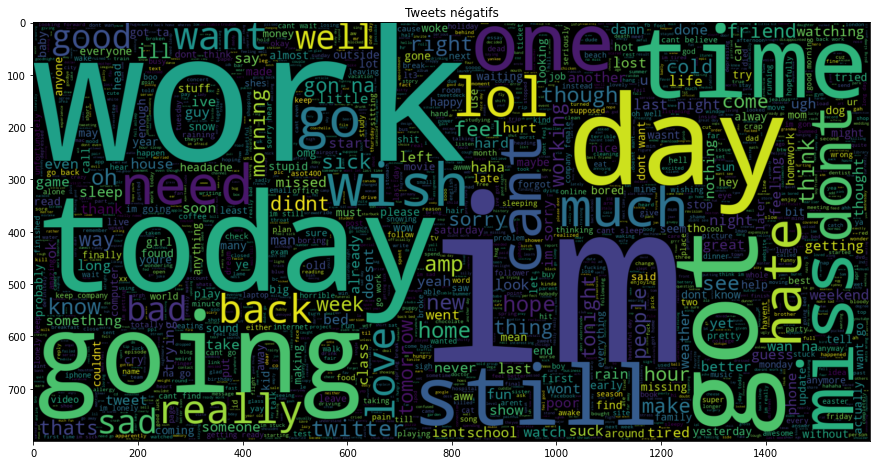

In [15]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 0].cleaned_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Tweets négatifs')

### 2.3 Splitting dataset in train and test

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df['cleaned_text'].values, df['target'].values, test_size=0.2, random_state=1)
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test : ", x_test.shape)
print("y_test : ", y_test.shape)

x_train :  (25600,)
y_train :  (25600,)
x_test :  (6400,)
y_test :  (6400,)


## 3. Vectorization with CountVectorizer and classification

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer=CountVectorizer()

countVec_train=count_vectorizer.fit_transform(x_train) 
countVec_test=count_vectorizer.transform(x_test)
print("count_train : ", countVec_train.shape)
print("count_test : ", countVec_test.shape)

count_train :  (25600, 25161)
count_test :  (6400, 25161)


### 3.1 Classification with Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)

rf_clf_countVec = RandomForestClassifier()
rf_clf_countVec = rf_clf_countVec.fit(countVec_train, y_train)

In [19]:
from sklearn.metrics import accuracy_score
y_pred = rf_clf_countVec.predict(countVec_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 72.66%


Predicted,0,1
True,,
0,2313,856
1,894,2337


### 3.2 Classification using Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
np.random.seed(0)

lr_clf_countVec = LogisticRegression(max_iter=100, solver='liblinear')
lr_clf_countVec = lr_clf_countVec.fit(countVec_train, y_train)

In [21]:
from sklearn.metrics import accuracy_score
y_pred = lr_clf_countVec.predict(countVec_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 73.62%


Predicted,0,1
True,,
0,2291,878
1,810,2421


## 4. Vectorization with Tfidf (Term Frequency - Inverse Document) and classification

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer()

tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)
print("tfidf_train : ", tfidf_train.shape)                                                                                                                                                                                                                                                    
print("tfidf_test : ", tfidf_test.shape)

tfidf_train :  (25600, 25161)
tfidf_test :  (6400, 25161)


### 4.1 Classification with RandomForest

In [23]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)

rf_clf_tfidf = RandomForestClassifier()
rf_clf_tfidf = rf_clf_tfidf.fit(tfidf_train, y_train)

In [24]:
from sklearn.metrics import accuracy_score
y_pred = rf_clf_tfidf.predict(tfidf_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 72.69%


Predicted,0,1
True,,
0,2318,851
1,897,2334


### 4.2 Classification using Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
np.random.seed(0)

lr_clf_tfidf = LogisticRegression(max_iter=100, solver='liblinear')
lr_clf_tfidf = lr_clf_tfidf.fit(tfidf_train, y_train)

In [26]:
from sklearn.metrics import accuracy_score
y_pred = lr_clf_tfidf.predict(tfidf_test)

score=accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 74.11%


Predicted,0,1
True,,
0,2313,856
1,801,2430


## 5. Vectorization with Word2Vec trained with Gensim on this corpus


I named the model **trained_w2v**.

In [27]:
! pip install --upgrade gensim
import gensim
print(gensim.__version__)

     |████████████████████████████████| 24.1 MB 25.6 MB/s            
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
4.1.2


J'ai travaillé avec la version **4.1.2** de Gensim.

### 5.1 Training of Word2Vec on this corpus

In [28]:
from gensim.models import Word2Vec

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        
        for sentence in df['cleaned_text'].values:
            yield sentence.split()

sentences = MyCorpus()
# I eliminate tokens whose frequency is less than 10
trained_w2v = Word2Vec(sentences=sentences, min_count=10, vector_size=100)
print(trained_w2v)

Word2Vec(vocab=2667, vector_size=100, alpha=0.025)


### 5.2 Viewing Word Embeddings

In [29]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(0)

def visualize_embeddings(wv):
    num_dimensions = 2

    vectors = np.asarray(wv.vectors)
    labels = np.asarray(wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

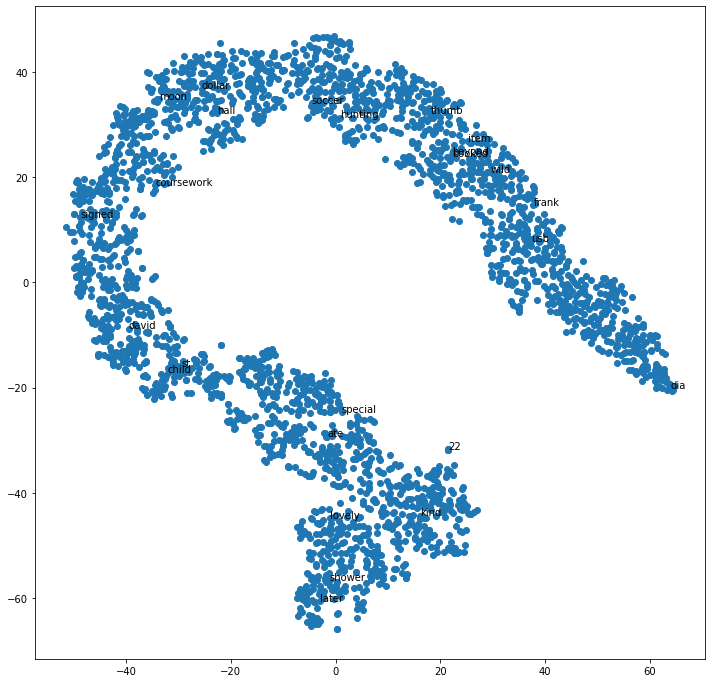

In [30]:
visualize_embeddings(trained_w2v.wv)

### 5.3 Sentences embeddings
The technique for using a Word2Vec on a sentence is to **average the vectors** of the words contained in the sentence.

In [31]:
def w2v_of_sentences(sentences, wv):
    vectors = np.zeros((len(sentences), wv.vector_size))
    for i, sentence in enumerate(sentences):
        sum_vector = np.zeros((1, wv.vector_size))
        tokens = sentence.split()
        for token in tokens:
            try:
              sum_vector += wv[token]
            except:
              pass
        if len(tokens) > 0:
          vectors[i] = sum_vector / len(tokens)
        else:
          vectors[i] = sum_vector
    return vectors

In [32]:
w2v_train=w2v_of_sentences(x_train, trained_w2v.wv)
w2v_test=w2v_of_sentences(x_test, trained_w2v.wv)
print("w2v_train : ", w2v_train.shape)
print("w2v_test : ", w2v_test.shape)

w2v_train :  (25600, 100)
w2v_test :  (6400, 100)


### 5.4 Classification using Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)
rf_clf_trained_w2v = RandomForestClassifier()
rf_clf_trained_w2v = rf_clf_trained_w2v.fit(w2v_train, y_train)

In [34]:
from sklearn.metrics import accuracy_score
y_pred = rf_clf_trained_w2v.predict(w2v_test)

score = accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 63.31%


Predicted,0,1
True,,
0,2096,1073
1,1275,1956


### 5.5 Classification using Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
np.random.seed(0)
lr_clf_trained_w2v = LogisticRegression(max_iter=100, solver='liblinear')
lr_clf_trained_w2v = lr_clf_trained_w2v.fit(w2v_train, y_train)

In [36]:
from sklearn.metrics import accuracy_score
y_pred = lr_clf_trained_w2v.predict(w2v_test)

score = accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 63.27%


Predicted,0,1
True,,
0,1913,1256
1,1095,2136




## 6. Vectorization with pre-trained word embeddings (GloVe)

There are models already trained on tweets which are available through this link https://nlp.stanford.edu/data/glove.twitter.27B.zip. These models have been trained on a vocabulary of 1.2 million tokens.

After having decompressed the archive, I will test the model whose vectors have a size of 50.

I load the model with Gensim's **load_word2vec_format** function.

### 6.1 Loading word embeddings with Gensim 

In [37]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2022-01-11 10:50:17--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2022-01-11 10:50:18--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-01-11 10:50:18--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [38]:
pretrained_glove_w2v = gensim.models.KeyedVectors.load_word2vec_format('glove.twitter.27B.50d.txt', binary=False, no_header=True)

In [39]:
# vectorization of tweets
pretrained_glove_w2v_train=w2v_of_sentences(x_train, pretrained_glove_w2v)
pretrained_glove_w2v_test=w2v_of_sentences(x_test, pretrained_glove_w2v)
print("w2v_train : ", pretrained_glove_w2v_train.shape)
print("w2v_test : ", pretrained_glove_w2v_test.shape)

w2v_train :  (25600, 50)
w2v_test :  (6400, 50)


### 6.2 Classification using Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)
rf_clf_pretrained_glove_w2v = RandomForestClassifier()
rf_clf_pretrained_glove_w2v = rf_clf_pretrained_glove_w2v.fit(pretrained_glove_w2v_train, y_train)

In [41]:
from sklearn.metrics import accuracy_score
y_pred = rf_clf_pretrained_glove_w2v.predict(pretrained_glove_w2v_test)

score = accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 69.11%


Predicted,0,1
True,,
0,2259,910
1,1067,2164


### 6.3 Classification using Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
np.random.seed(0)
lr_clf_pretrained_glove_w2v = LogisticRegression(max_iter=100, solver='liblinear')
lr_clf_pretrained_glove_w2v = lr_clf_pretrained_glove_w2v.fit(pretrained_glove_w2v_train, y_train)

In [43]:
from sklearn.metrics import accuracy_score
y_pred = lr_clf_pretrained_glove_w2v.predict(pretrained_glove_w2v_test)

score = accuracy_score(y_test,y_pred)

print(f'Accuracy: {round(score*100,2)}%')
# Confusion matrix
pd.crosstab(y_test,y_pred, rownames=['True'], colnames=['Predicted'])

Accuracy: 69.42%


Predicted,0,1
True,,
0,2226,943
1,1014,2217


## 7. Classification using RNN
In this part, I will use the **pretrained word embeddings** of the previous part.

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Activation, Embedding, GRU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

To suit the Keras logic, I must convert sentences to lists of indices.

Moreover, the input data must have the same size, so I need to find the largest tweet size (after cleaning) and adjust the others according to that.

In [45]:
list_len = [len(tweet.split()) for tweet in df.cleaned_text]
maxLen = max(list_len)
print('maxLen:', maxLen)

maxLen: 24


In [46]:
def sentences_to_indices(X, w2v, max_len):
    
    m = X.shape[0]  # number of tweets
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        
        sentence_words = X[i].split()

        for j, w in enumerate(sentence_words):
          try:
            X_indices[i, j] =  w2v.get_index(w)
          except:
            try:
              X_indices[i, j] =  w2v.get_index('unk')
            except:
              pass
    
    return X_indices

In [47]:
# Transform the tweets tokens to indices
x_train_indices = sentences_to_indices(x_train, pretrained_glove_w2v, maxLen)
x_test_indices = sentences_to_indices(x_test, pretrained_glove_w2v, max_len = maxLen)


Below I found a function to match the model loaded with Gensim to an Embedding layer from Keras. I found that here https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow .

In [48]:
def gensim_to_keras_embedding(gensim_w2v, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = gensim_w2v  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

**The RNN architecture**

In [49]:
def My_RNN(input_shape, wv):

    sentence_indices = Input(shape=input_shape, dtype=np.int32)
    
    embedding_layer =  gensim_to_keras_embedding(wv, train_embeddings = False)  # embeddings need to be fixed as I don't want to train them
    
    embeddings = embedding_layer(sentence_indices)   
    
    X = LSTM(128, return_sequences=True)(embeddings)
    # X = Dropout(0.5)(X)
    X = LSTM(128)(X)
    # X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = tf.keras.models.Model(sentence_indices, X)
    
    return model

model = My_RNN((maxLen,), pretrained_glove_w2v)
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 50)            59675700  
_________________________________________________________________
lstm (LSTM)                  (None, 24, 128)           91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 59,899,061
Trainable params: 223,361
Non-trainable params: 59,675,700
_________________________________________________________________


In [50]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
history = model.fit(
    x = x_train_indices,
    y = y_train,
    epochs = 10,
    batch_size = 64,
    shuffle=True,
    verbose=2)

    #validation_data = (x_test_indices, y_test),

2022-01-11 10:57:55.667945: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
400/400 - 26s - loss: 0.6122 - accuracy: 0.6546
Epoch 2/10
400/400 - 22s - loss: 0.5584 - accuracy: 0.7109
Epoch 3/10
400/400 - 22s - loss: 0.5353 - accuracy: 0.7296
Epoch 4/10
400/400 - 22s - loss: 0.5162 - accuracy: 0.7451
Epoch 5/10
400/400 - 22s - loss: 0.5062 - accuracy: 0.7519
Epoch 6/10
400/400 - 22s - loss: 0.4868 - accuracy: 0.7641
Epoch 7/10
400/400 - 22s - loss: 0.4716 - accuracy: 0.7766
Epoch 8/10
400/400 - 22s - loss: 0.4582 - accuracy: 0.7836
Epoch 9/10
400/400 - 21s - loss: 0.4377 - accuracy: 0.7960
Epoch 10/10
400/400 - 22s - loss: 0.4141 - accuracy: 0.8099


In [52]:
loss, acc = model.evaluate(x_test_indices, y_test)

print(f'Test Accuracy: {round(acc*100,2)}%')

200/200 [==============================] - 4s 15ms/step - loss: 0.5685 - accuracy: 0.7269
Test Accuracy: 72.69%


**Conclusion :** The best score on the test set that I got is 74%. All the approaches I have tested have almost the same performance. 

Much more thorough cleaning should improve the results.